In [17]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
Algoritmos para realizar el informe semanal de las concentraciones de PM2.5 de los viajes de CC en bicicleta
desde base de datos para las fechas especificadas.

__author__: "Grupo Aire"
__copyright__: "SIATA"
__version__: "1.0.1"
__maintaner__:"Alejandra Montejo"
__email__:"alejandra.montejo@hotmail.com"
__status__:"Developer"
__Fecha_Actualización__:"2024/07/16"
'''

from folium.plugins import FloatImage #Librería agregada Jul- 2024
from folium.plugins import HeatMap
from selenium import webdriver
import base64 #Librería agregada Jul- 2024
import branca
import branca.colormap as branca_folium_cm
import branca.colormap as cm
import datetime as dt
from dateutil.relativedelta import relativedelta
import folium
import geopandas as gpd
import geopy.distance
import matplotlib.image as mpimg #Librería agregada Jul- 2024
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import psycopg2
import shapefile
import time


In [110]:

#==============================================================================
# Consulta Datos
#==============================================================================

import datetime as dt
from dateutil.relativedelta import relativedelta
#get first and last day of this and last month)
# Fecha actual
today = dt.date.today()

# Último día del rango: un día antes del actual
fn_day_this_week = today - relativedelta(days=1)

fr_day_last_month = fn_day_this_week - relativedelta(days=7)
fn_day_this_week=str(fn_day_this_week)
fr_day_last_month=str(fr_day_last_month)

#print (fr_day_last_month, fn_day_this_week)



hostC   = "192.168.1.13"
hostC2  = "localhost"
userC   = "SIATA_CC_V2_Consulta"
passwdC = "ciudadanos_2568"
dbnameC = "ciudadanos_cientificos"
#psycopg2.connect("dbname='ciudadanos_cientificos' user='SIATA_CC_V2_Consulta' host='192.168.1.13' password='ciudadanos_2568'")
conn_db = psycopg2.connect("dbname='" + dbnameC + "' user='" + userC +"' host='" + hostC + "' password='" + passwdC + "'")
conn_db

Datos=pd.read_sql("""select distinct "hora","fechaHora", "pm25_df", "codigoSerial", "latitud","longitud",fecha
from "DatoCiudadanoCientificoBicicletaCrudo"
where"fecha" between '""" + fr_day_last_month + """' and '""" + fn_day_this_week + """'
Order by "codigoSerial" asc, "fechaHora" asc
;""", conn_db)

In [111]:
Datos

hora           fechaHora  pm25_df  codigoSerial   latitud  \
0     04:21:38 2024-11-19 04:21:38     19.0         10017  6.267170   
1     04:21:48 2024-11-19 04:21:48     19.0         10017  6.267170   
2     04:21:58 2024-11-19 04:21:58     18.0         10017  6.267177   
3     04:22:08 2024-11-19 04:22:08     19.0         10017  6.267182   
4     04:22:18 2024-11-19 04:22:18     19.0         10017  6.267182   
...        ...                 ...      ...           ...       ...   
8621  17:28:54 2024-11-20 17:28:54     11.0         10037  6.266248   
8622  17:29:54 2024-11-20 17:29:54      8.0         10037  6.266248   
8623  17:30:04 2024-11-20 17:30:04      8.0         10037  6.266248   
8624  17:30:14 2024-11-20 17:30:14      8.0         10037  6.266248   
8625  17:30:24 2024-11-20 17:30:24      8.0         10037  6.266248   

       longitud       fecha  
0    -75.555443  2024-11-19  
1    -75.555443  2024-11-19  
2    -75.555435  2024-11-19  
3    -75.555420  2024-11-19  
4    -75.555420  2024-11-19  
...         ...         ...  
8621 -75.598938  2024-11-20  
8622 -75.598938  2024-11-20  
8623 -75.598938  2024-11-20  
8624 -75.598938  2024-11-20  
8625 -75.598938  2024-11-20  

[8626 rows x 7 columns]

In [75]:

#==============================================================================
# organizando datos
#==============================================================================
df= Datos.copy(deep=True)
df['fechaHora'] = pd.to_datetime(df['fechaHora'])
df = df[(df['longitud'].between(-180, 180)) & 
     (df['latitud'].between(-90, 90)) & 
     (df['codigoSerial'].between(10000, 11000)) & 
     (df['pm25_df'].between(0, 900))]

df['tiempo'] = pd.to_datetime(df['fechaHora']) - pd.to_datetime(df['fechaHora'].shift())
df['tiempo'] = df['tiempo'].dt.total_seconds().fillna(0)

In [76]:
#==============================================================================
# Calculando en la base de datos, viajes por persona y totales dependiendo de los codigos seriales
#==============================================================================

# Inicializar listas para viajes y distancias
viajes_per = [1]
viajes_tot = [1]
dist = []
a = 1
b = 1

# Calcular viajes por sensor y total
for i in range(1, len(df)):
    dist.append(geopy.distance.distance(
        (df.latitud.iloc[i], df.longitud.iloc[i]), 
        (df.latitud.iloc[i-1], df.longitud.iloc[i-1])
    ).m)
    
    if df['codigoSerial'].iloc[i] == df['codigoSerial'].iloc[i-1]:
        if df['tiempo'].iloc[i] < 30 * 60:
            viajes_per.append(a)
            viajes_tot.append(b)
        else:
            a += 1
            viajes_per.append(a)
            b += 1
            viajes_tot.append(b)
    else:
        a = 1
        viajes_per.append(a)
        b += 1
        viajes_tot.append(b)

df['viajes_per'] = viajes_per
df['viajes_tot'] = viajes_tot
#==============================================================================
# Calculando viajes cortos, para excluirlos de la base de datos
#==============================================================================
# Función para calcular la distancia máxima
def dismax(coor_1, coor_2):
    return geopy.distance.distance(coor_1, coor_2).m

# Calcular la distancia desde el origen y clasificar viajes cortos
for (codigoSerial, viajes_per), grupo in df.groupby(['codigoSerial', 'viajes_per']):
    coor1 = (grupo.iloc[0].latitud, grupo.iloc[0].longitud)
    grupo['dis_ori'] = grupo.apply(lambda row: dismax(coor1, (row.latitud, row.longitud)), axis=1)
    df.loc[(df.codigoSerial == codigoSerial) & (df.viajes_per == viajes_per), 'dis_ori'] = grupo['dis_ori']
    
    if grupo['dis_ori'].max() <= 300:
        df.loc[(df.codigoSerial == codigoSerial) & (df.viajes_per == viajes_per), 'viaje_corto'] = True
    else:
        df.loc[(df.codigoSerial == codigoSerial) & (df.viajes_per == viajes_per), 'viaje_corto'] = False

# Filtrar solo viajes largos
df_largos = df[df['viaje_corto'] == False].copy()

# Inicializar listas para distancia acumulada y puntos
dist_acumulada = [0]
punto = [1]

# Calcular distancia acumulada y puntos
for i in range(1, len(df_largos)):
    distancia = geopy.distance.distance(
        (df_largos.latitud.iloc[i], df_largos.longitud.iloc[i]),
        (df_largos.latitud.iloc[i-1], df_largos.longitud.iloc[i-1])
    ).km
    
    if df_largos['codigoSerial'].iloc[i] == df_largos['codigoSerial'].iloc[i-1]:
        dist_acumulada.append(dist_acumulada[-1] + distancia)
        punto.append(punto[-1] + 1)
    else:
        dist_acumulada.append(distancia)
        punto.append(1)

df_largos['dist_acumulada'] = dist_acumulada
df_largos['punto'] = punto

# Reiniciar las listas para viajes por sensor y total
viajes_per = [1]
viajes_tot = [1]
dist = [0]
a = 1
b = 1

# Calcular viajes y distancia acumulada nuevamente
for i in range(1, len(df_largos)):
    if df_largos['codigoSerial'].iloc[i] == df_largos['codigoSerial'].iloc[i-1]:
        if df_largos['tiempo'].iloc[i] < 30 * 60:
            viajes_per.append(a)
            viajes_tot.append(b)
        else:
            a += 1
            viajes_per.append(a)
            b += 1
            viajes_tot.append(b)
    else:
        a = 1
        viajes_per.append(a)
        b += 1
        viajes_tot.append(b)
        
    if viajes_per[i] == viajes_per[i-1]:
        dist.append(geopy.distance.distance(
            (df_largos.latitud.iloc[i], df_largos.longitud.iloc[i]),
            (df_largos.latitud.iloc[i-1], df_largos.longitud.iloc[i-1])
        ).km)
    else:
        dist.append(0)

df_largos['viajes_per'] = viajes_per
df_largos['viajes_tot'] = viajes_tot
df_largos['distance'] = dist
df=df_largos


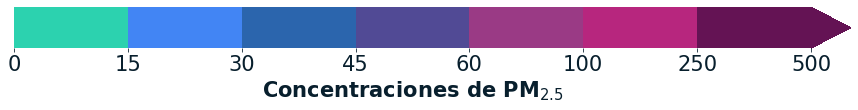
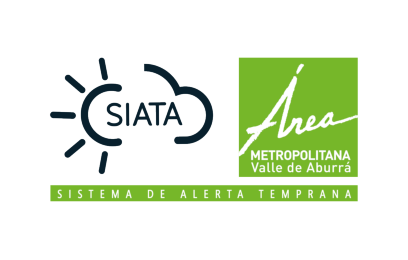

In [77]:
import datetime as dt
from dateutil.relativedelta import relativedelta
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import sys
import base64
from folium.plugins import FloatImage

# import branca
sys.path.append('/home/calidadaire/Paquete/')
%matplotlib inline
import airquality.read_data as read
from airquality.core import *

# Definición del nuevo colormap
colors = [
    '#2cd2af',  # 0 - 15
    '#4285f4',  # 15 - 30
    '#2b65ad',  # 30 - 45
    '#514a95',  # 45 - 60
    '#9a3a85',  # 60 - 100
    '#b7267e',  # 100 - 250
    '#641354'   # 250 - ∞
]
vmin = 0
vmax = 900
index = [0, 15, 30, 45, 60, 100, 250,500]

# Creación del colormap
colormap = branca.colormap.StepColormap(
    colors=colors,
    vmin=vmin,
    vmax=vmax,
    index=index
)

medians_lat = 6.15  # latitud de Medellín
medians_lon = -75.48  # longitud de Medellín

# Nombre del archivo
mes='Jul'
fname = mes + '.html'

# Crear el mapa base
# Crear el mapa base
map = folium.Map(
    location=[medians_lat, medians_lon], 
    zoom_start=10, 
    tiles="Cartodb Positron", 
    control_scale=True
)
#map = folium.Map(
#    location=[medians_lat, medians_lon], 
#    zoom_start=10, 
#    tiles="https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png", 
#    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
#    control_scale=True)#,
   # width='40%', 
   # height='80%')
# Extraer datos del DataFrame
lat = df.latitud.values
lon = df.longitud.values
value = df.pm25_df.values
df = pd.DataFrame({'lat': lat, 'lon': lon, 'value': value})
lat = list(df.lat)
lon = list(df.lon)
pow = list(df.value)

for loc, p in zip(zip(lat, lon), pow):
    folium.Circle(
        location=loc,
        radius=15,
        fill=True,
        color=colormap(p),
        fill_opacity=0.7
    ).add_to(map)

# Añadir Shape AMVA
shape_amva = gpd.read_file('/home/calidadaire/Paquete/tools/Maps/Shape/AMVA/AreaMetropolitana.shp')
folium.GeoJson(
    shape_amva,
    style_function=lambda feature: {
        'fillColor': '#808080',  # Gray color
        'color': 'gray',         # Border color
        'weight': 1,             # Border width
        'fillOpacity': 0.2       # Transparency (0: transparent, 1: opaque)
    }
).add_to(map)

# Ruta de la imagen
Escala_path = '/home/amontejo/jupyter/Figura/CC/colormap.png'
Logo_path = '/home/amontejo/jupyter/Figura/CC/logo_saved2.png'

# Leer y codificar la imagen en base64
with open(Escala_path, 'rb') as lf:
    b64_content_escala = base64.b64encode(lf.read()).decode('utf-8')

with open(Logo_path, 'rb') as lf:
    b64_content_logo = base64.b64encode(lf.read()).decode('utf-8')

# Añadir imágenes al mapa
FloatImage('data:image/png;base64,{}'.format(b64_content_escala), bottom=5, left=10,width='70%').add_to(map)
FloatImage('data:image/png;base64,{}'.format(b64_content_logo), bottom=5, left=80,width='20%').add_to(map)

fg = folium.FeatureGroup(name=fname.split('.')[0])

# Añadir colormap y grupo de características al mapa
map.add_child(fg)

# Guardar el mapa
map.save(os.path.join('conmap.html'))

# Mostrar el mapa
map

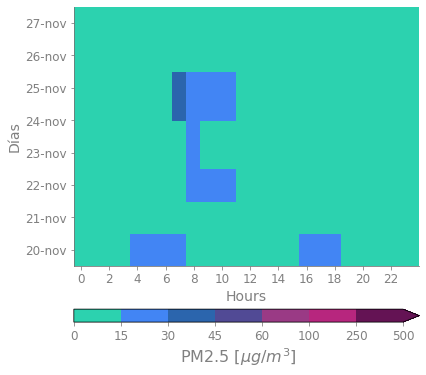

In [87]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import numpy as np
import pandas as pd

# Definición del nuevo colormap
colors = [
    '#2cd2af',  # 0 - 15
    '#4285f4',  # 15 - 30
    '#2b65ad',  # 30 - 45
    '#514a95',  # 45 - 60
    '#9a3a85',  # 60 - 100
    '#b7267e',  # 100 - 250
    '#641354'   # 250 - ∞
]
vmin = 0
vmax = 500
index = [0, 15, 30, 45, 60, 100, 250]


# Trabajamos directamente con df_largos
df = df_largos.copy()
df['fechaHora'] = pd.to_datetime(df['fechaHora'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fechaHora', inplace=True)
# Crear una tabla pivote: filas (index) por días, columnas por horas
df_pivot = pd.pivot_table(
    df, 
    index=df.index.date,  # Agrupa por día
    columns=df.index.hour,  # Agrupa por hora
    values='pm25_df',  # Valores de PM2.5
    aggfunc='mean'  # Promedio por hora
)

# Reemplazar valores faltantes con 0 (o usa NaN si lo prefieres)
df_pivot.fillna(0, inplace=True)

# Crear colormap y normalización para matplotlib
a = mpl.colors.ListedColormap(colors)
bounds = index + [vmax]  # Extender límites superiores
norm = mpl.colors.BoundaryNorm(bounds, len(bounds) - 1)

# Crear figura

fig = plt.figure(2,figsize=(6, 6),facecolor='w',edgecolor='w')
plt.subplots_adjust(wspace=.2,hspace=.35,bottom=0.2,left=0.1,right=0.9,top=0.8)
# Configurar ejes
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["xtick.color"] = 'gray'
plt.rcParams["ytick.color"] = 'gray'

ax = fig.add_subplot(111)

# Gráfica de pcolor
plt.pcolor(
    df_pivot.columns,  # Las horas son las columnas
    df_pivot.index,  # Los días son el índice
    df_pivot,  # Valores de PM2.5
    cmap=a,
    norm=norm
)

# Etiquetas y formato
ax.set_ylabel('Días', fontsize=14, color='gray')
ax.set_xlabel('Hours', fontsize=14, color='gray')

# Configurar el eje Y para mostrar días
ax.yaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.yaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.yaxis_date()

# Configurar el eje X
ax.set_xticks(np.arange(0, 24, 2))

# Ajustar apariencia de los bordes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color((0.45, 0.45, 0.45))
ax.spines['bottom'].set_color((0.45, 0.45, 0.45))

# Barra de colores
ax1 = fig.add_axes((0.1, 0.07, 0.8, 0.03))
ca = mpl.colorbar.ColorbarBase(
    ax1, 
    cmap=a, 
    norm=norm, 
    ticks=indices, 
    orientation='horizontal', 
    extend='max'
)
ax1.set_xlabel('PM2.5 [$\\mu g/m^3$]', fontsize=16, color='gray')

# Guardar figura
plt.savefig('Cycle_PM2.5_Days.pdf', bbox_inches='tight')
plt.show()


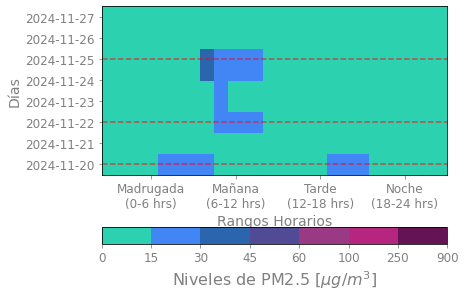

In [92]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import numpy as np
import pandas as pd

# Colores y rangos para PM2.5
colors = [
    '#2cd2af',  # 0 - 15
    '#4285f4',  # 15 - 30
    '#2b65ad',  # 30 - 45
    '#514a95',  # 45 - 60
    '#9a3a85',  # 60 - 100
    '#b7267e',  # 100 - 250
    '#641354',  # 250 - 500
    '#4e0a2a'   # 500 - ∞
]
indices = [0, 15, 30, 45, 60, 100, 250, 500]
vmin = 0
vmax = 900

# Trabajamos directamente con df_largos
df = df_largos.copy()
df['fechaHora'] = pd.to_datetime(df['fechaHora'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fechaHora', inplace=True)
# Crear una tabla pivote: filas (index) por días, columnas por horas
df_pivot = pd.pivot_table(
    df, 
    index=df.index.date,  # Agrupa por día
    columns=df.index.hour,  # Agrupa por hora
    values='pm25_df',  # Valores de PM2.5
    aggfunc='mean'  # Promedio por hora
)

# Reemplazar valores faltantes con 0
df_pivot.fillna(0, inplace=True)

# Crear colormap y normalización para matplotlib
a = mpl.colors.ListedColormap(colors)
bounds = index + [vmax]  # Extender límites superiores
norm = mpl.colors.BoundaryNorm(bounds, len(bounds) - 1)

### 1. Mapa de calor con rangos horarios y días destacados
fig, ax = plt.subplots(figsize=(6, 6), facecolor='w', edgecolor='w')
plt.subplots_adjust(wspace=0.2, hspace=0.35, bottom=0.2, left=0.1, right=0.9, top=0.8)
# Gráfica de pcolor
heatmap = ax.pcolor(
    df_pivot.columns, 
    df_pivot.index, 
    df_pivot, 
    cmap=a,
    norm=norm
)

# Etiquetas de ejes
ax.set_ylabel('Días', fontsize=14, color='gray')
ax.set_xlabel('Rangos Horarios', fontsize=14, color='gray')

# Cambiar etiquetas del eje X a rangos horarios
ax.set_xticks([3, 9, 15, 21])  # Centros de los rangos
ax.set_xticklabels(['Madrugada\n(0-6 hrs)', 'Mañana\n(6-12 hrs)', 
                    'Tarde\n(12-18 hrs)', 'Noche\n(18-24 hrs)'])

# Resaltar días críticos
critical_days = df_pivot.mean(axis=1).nlargest(3)  # Los 3 días con PM2.5 más altos
for day in critical_days.index:
    ax.axhline(y=day, color='red', linestyle='--', alpha=0.6)

# Barra de colores
cbar = plt.colorbar(heatmap, orientation='horizontal', pad=0.2, ax=ax)

# Etiquetas para los rangos
#cbar.ax.set_xticklabels([
#    'Bueno (0-15)', 'Moderado (15-30)', 'Regular (30-45)', 
#    'Poco saludable (45-60)', 'Insalubre (60-100)', 
#    'Muy insalubre (100-250)', 'Peligroso (250-500)', 'Extremo (>500)'
#])

cbar.set_label('Niveles de PM2.5 [$\\mu g/m^3$]', fontsize=16, color='gray')

# Guardar figura
plt.savefig('Improved_PM2.5_Heatmap.pdf', bbox_inches='tight')

plt.show()



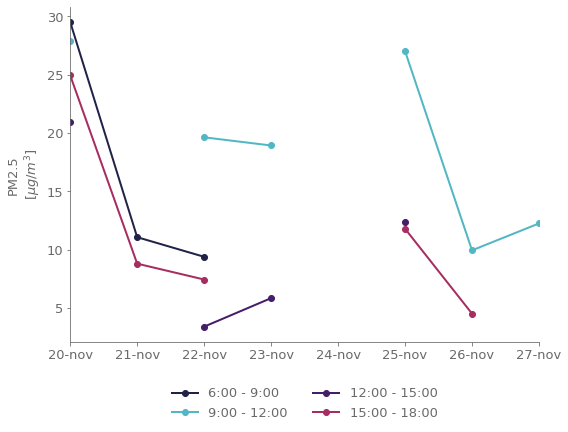

In [107]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Reestablecer el índice y usar 'fechaHora' como índice
df1 = df_largos.copy()
df1['fechaHora'] = pd.to_datetime(df1['fechaHora'], errors='coerce')  # Asegurar formato datetime
df1.set_index('fechaHora', inplace=True)  # Establecer 'fechaHora' como nuevo índice



# Definir la fuente personalizada (opcional)
prop_2 = fm.FontProperties(fname='/home/calidadaire/ModuloAire/Tools/AvenirLTStd-Black.ttf')

# Filtrar por intervalos horarios y calcular promedio diario
intervalos = [
    {'label': '6:00 - 9:00', 'start': 0, 'end': 6, 'color': '#202248'},
    {'label': '9:00 - 12:00', 'start': 6, 'end': 12, 'color': '#52b7c4'},
    {'label': '12:00 - 15:00', 'start': 12, 'end': 18, 'color': '#451d69'},
    {'label': '15:00 - 18:00', 'start': 18, 'end': 24, 'color': '#a62d60'},
 
]

# Crear un diccionario para almacenar los datos por intervalo
data_por_intervalo = {}

for intervalo in intervalos:
    temp_df = df1.loc[(df1.index.hour >= intervalo['start']) & (df1.index.hour <= intervalo['end'])]
    temp_df["pm25_df"] = temp_df["pm25_df"].where(temp_df["pm25_df"] > 0.0, np.nan)  # Ignorar valores negativos
    temp_df = temp_df['pm25_df'].resample('D').mean()  # Agrupar por día
    if not temp_df.empty:  # Verificar si el intervalo tiene datos
        data_por_intervalo[intervalo['label']] = {'data': temp_df, 'color': intervalo['color']}

# Crear la gráfica
### 1. Mapa de calor con rangos horarios y días destacados
fig, ax = plt.subplots(figsize=(8, 6), facecolor='w', edgecolor='w')
plt.subplots_adjust(wspace=0.2, hspace=0.35, bottom=0.2, left=0.1, right=0.9, top=0.8)
for intervalo, info in data_por_intervalo.items():
    info['data'].plot(ax=ax, label=intervalo, color=info['color'], linestyle='-', marker='o', linewidth=2)

# Ajustar los elementos de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')

ax.set_ylabel('PM2.5\n['+'$\mu g/m^{3}$'+']', color='dimgrey', fontsize=13)
ax.set_xlabel('', fontsize=14, color='dimgrey')

# Asegurando que los ticks sean de color 'dimgrey'
ax.tick_params(axis='both', which='both', colors='dimgrey', labelsize=13)

# Establecer formato de fecha en el eje X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Añadir la leyenda
leg = plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', fontsize=13, ncol=2, frameon=False)
for text in leg.get_texts():
    text.set_color('dimgrey')  # Ajustar el color de las etiquetas de la leyenda

# Ajustes finales
fig.tight_layout()
fig.set_facecolor('w')
plt.savefig('CCBici_Horas.png', dpi=300, bbox_inches='tight')
plt.show()


In [102]:
df['fechaHora'].min()

Timestamp('2024-11-20 06:30:54')

In [103]:
df['fechaHora'].max()

Timestamp('2024-11-27 08:55:00')